In [8]:
from google.cloud import storage
import argparse
import gzip
import os
import sys
import time
from multiprocessing import Pool

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from utils import gcs_utils as gcs
from utils import model_and_evaluate_cluster as ev
import urllib.parse
import urllib.request

import io 

import importlib
import hdbscan
import networkx as nx 
import pickle

import obonet

from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf



# Model Comparison Graphs

In [37]:
# Just go to our results spreadsheet "Model Outputs" tab. File > download > TSV
modeloutput = pd.read_csv('Results - Model Outputs.tsv', 
                          sep='\t',
                         header=3, thousands=',')

# Clean up
    # Remove NA
    # Remove "Do not use" embeddings (CurveNet)
    # Select just a few cols

modeloutput = modeloutput[~modeloutput.goodplace_pairs_pct.isna()]
modeloutput = modeloutput[~modeloutput.embedding.str.contains('DO NOT USE')]
modeloutput = modeloutput[['id', 'model', 'embedding', 'largest_clus', 
                           'clusters', 'silhouette', 'db',
                           'noise_pct', 'func_sim', 
                           'goodplace_pairs_pct', 'goodplace_clusters_pct',
                           'metrics_coverage_pct']]

In [38]:
modeloutput.head()

,id,model,embedding,largest_clus,clusters,silhouette,db,noise_pct,func_sim,goodplace_pairs_pct,goodplace_clusters_pct,metrics_coverage_pct
3,A2EP,DBSCAN,SeqVec,691.0,1534.0,0.37,0.75,0.6299,0.3943,0.6078,0.4437,0.6532
5,A1EP,DBSCAN,DeepFold,4571.0,1221.0,0.00,0.93,0.5135,0.0508,0.0372,0.5711,0.0241
7,A3EP,DBSCAN,Structure LSTM + SeqVec,232.0,714.0,0.55,0.48,0.8792,0.7392,0.8735,0.5855,0.8043
11,B2EP,HDBSCAN,SeqVec,416.0,741.0,0.23,1.36,0.5555,0.5021,0.5686,0.2363,0.8117
12,B2EPA,HDBSCAN,SeqVec,401.0,314.0,0.32,1.10,0.6898,0.4601,0.4423,0.3131,0.6491


In [39]:
modeloutput.shape

(31, 12)

In [41]:
data=modeloutput
x="clusters"
y="noise_pct"

X = sm.add_constant(modeloutput[x])
Y = modeloutput[y]

est = sm.OLS(Y, sm.add_constant(X))
est2 = est.fit()
print(est2.summary())


                            OLS Regression Results                            
Dep. Variable:              noise_pct   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.383
Method:                 Least Squares   F-statistic:                     19.62
Date:                Mon, 06 Dec 2021   Prob (F-statistic):           0.000123
Time:                        15:39:26   Log-Likelihood:                 27.826
No. Observations:                  31   AIC:                            -51.65
Df Residuals:                      29   BIC:                            -48.78
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7501      0.027     28.219      0.0

/Users/haeranglee/opt/anaconda3/envs/pss/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


'Noise pct'

(0.0, 1.1)

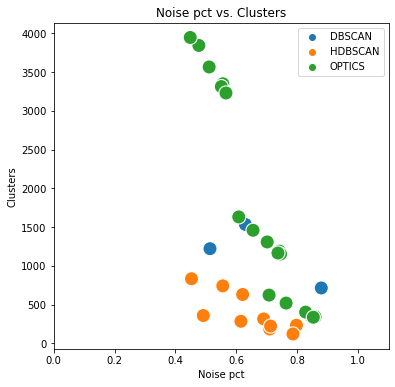

In [97]:
data=modeloutput
x="noise_pct"
y="clusters"
hue='model'

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=hue,
                s=200
                )
ax.legend(loc='best')

x_proper = x.capitalize().replace('_', ' ')
y_proper = y.capitalize().replace('_', ' ')
ax.set(xlabel=x_proper, 
       ylabel=y_proper,
      title =x_proper + " vs. " + y_proper)

ax.set_xlim(0, 1.1)

We control the noise level. So put that into X. Let's see what affect it has on structural similarity.

(0.0, 1.1)

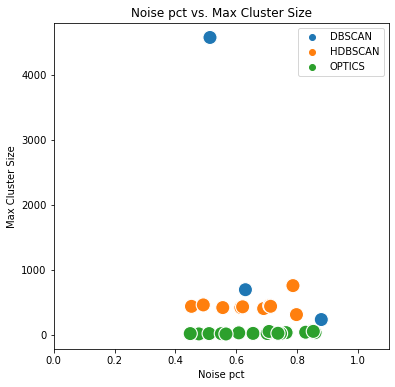

In [96]:
data=modeloutput
x="noise_pct"
y="largest_clus"
hue='model'

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=hue,
                s=200
                )
ax.legend(loc='best')

x_proper = x.capitalize().replace('_', ' ')
y_proper = 'Max Cluster Size'
ax.set(xlabel=x_proper, 
       ylabel=y_proper,
      title =x_proper + " vs. " + y_proper)

ax.set_xlim(0, 1.1)

(0.0, 1.1)

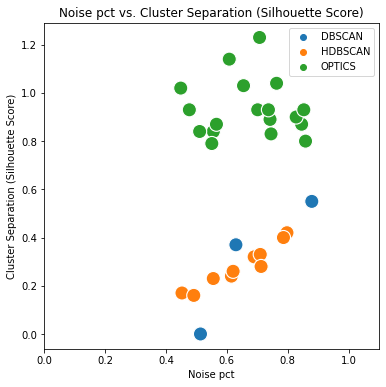

In [91]:
data=modeloutput
x="noise_pct"
y="silhouette"
hue='model'

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=hue,
                s=200
                )
ax.legend(loc='best')

x_proper = x.capitalize().replace('_', ' ')
y_proper = 'Cluster Separation (Silhouette Score)'
ax.set(xlabel=x_proper, 
       ylabel=y_proper,
      title =x_proper + " vs. " + y_proper)
ax.set_xlim(0, 1.1)

Then we want to know if we are giving up on the things that MATTER

(0.0, 1.1)

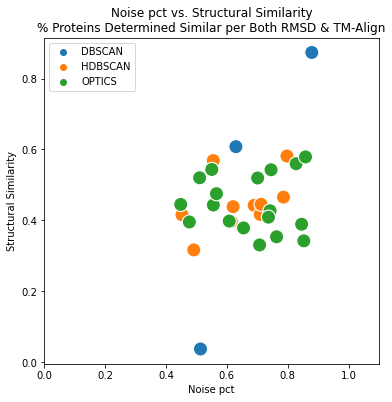

In [99]:
data=modeloutput
x="noise_pct"
y="goodplace_pairs_pct"
hue='model'

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=hue,
                s=200
                )
ax.legend(loc='best')

x_proper = x.capitalize().replace('_', ' ')
y_proper = 'Structural Similarity'
ax.set(xlabel=x_proper, 
       ylabel=y_proper,
      title =x_proper + " vs. " + y_proper + '\n% Proteins Determined Similar per Both RMSD & TM-Align')

ax.set_xlim(0, 1.1)

In [86]:
mod = smf.ols("goodplace_pairs_pct ~ noise_pct", 
              data=modeloutput[modeloutput.model=='OPTICS']).fit()
print(mod.summary())

                             OLS Regression Results                            
Dep. Variable:     goodplace_pairs_pct   R-squared:                       0.001
Model:                             OLS   Adj. R-squared:                 -0.062
Method:                  Least Squares   F-statistic:                   0.01459
Date:                 Mon, 06 Dec 2021   Prob (F-statistic):              0.905
Time:                         16:14:33   Log-Likelihood:                 20.495
No. Observations:                   18   AIC:                            -36.99
Df Residuals:                       16   BIC:                            -35.21
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4594      0.102      4.48

/Users/haeranglee/opt/anaconda3/envs/pss/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [87]:
mod = smf.ols("goodplace_clusters_pct ~ noise_pct", 
              data=modeloutput[modeloutput.model=='OPTICS']).fit()
print(mod.summary())

                              OLS Regression Results                              
Dep. Variable:     goodplace_clusters_pct   R-squared:                       0.024
Model:                                OLS   Adj. R-squared:                 -0.037
Method:                     Least Squares   F-statistic:                    0.3876
Date:                    Mon, 06 Dec 2021   Prob (F-statistic):              0.542
Time:                            16:14:57   Log-Likelihood:                 26.847
No. Observations:                      18   AIC:                            -49.69
Df Residuals:                          16   BIC:                            -47.91
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   

/Users/haeranglee/opt/anaconda3/envs/pss/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [77]:
modeloutput.columns

Index(['id', 'model', 'embedding', 'largest_clus', 'clusters', 'silhouette',
       'db', 'noise_pct', 'func_sim', 'goodplace_pairs_pct',
       'goodplace_clusters_pct', 'metrics_coverage_pct'],
      dtype='object')

(0.0, 1.1)

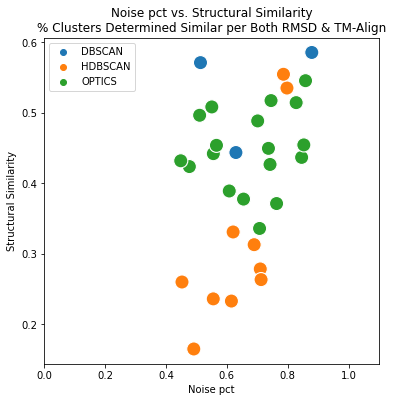

In [94]:
data=modeloutput
x="noise_pct"
y="goodplace_clusters_pct"
hue='model'

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=hue,
                s=200
                )
ax.legend(loc='best')

x_proper = x.capitalize().replace('_', ' ')
y_proper = 'Structural Similarity'
ax.set(xlabel=x_proper, 
       ylabel=y_proper,
      title =x_proper + " vs. " + y_proper + '\n% Clusters Determined Similar per Both RMSD & TM-Align')

ax.set_xlim(0, 1.1)

[Text(0.5, 0, 'Largest clus'),
 Text(0, 0.5, 'Goodplace pairs pct'),
 Text(0.5, 1.0, 'Largest clus vs. Goodplace pairs pct - not DBSCAN')]

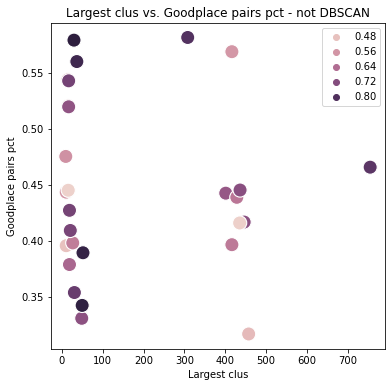

In [89]:
data=modeloutput[modeloutput.model !='DBSCAN']
x="largest_clus"
y="goodplace_pairs_pct"
hue='noise_pct'

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=hue,
                s=200
                )
ax.legend(loc='best')

x_proper = x.capitalize().replace('_', ' ')
y_proper = y.capitalize().replace('_', ' ')
ax.set(xlabel=x_proper, 
       ylabel=y_proper,
      title =x_proper + " vs. " + y_proper + ' - ' + 'not DBSCAN' )

In [84]:
modeloutput.embedding.unique()

array(['SeqVec', 'DeepFold', 'Structure LSTM + SeqVec'], dtype=object)

[Text(0.5, 0, 'Goodplace pairs pct'),
 Text(0, 0.5, 'Goodplace clusters pct'),
 Text(0.5, 1.0, 'Goodplace pairs pct vs. Goodplace clusters pct')]

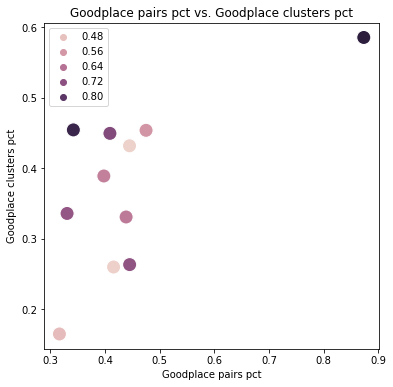

In [85]:
data=modeloutput[modeloutput.embedding == 'Structure LSTM + SeqVec']
x="goodplace_pairs_pct"
y="goodplace_clusters_pct"
hue='noise_pct'

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=hue,
                s=200
                )
ax.legend(loc='best')

x_proper = x.capitalize().replace('_', ' ')
y_proper = y.capitalize().replace('_', ' ')
ax.set(xlabel=x_proper, 
       ylabel=y_proper,
      title =x_proper + " vs. " + y_proper )

In [46]:
mod = smf.ols("goodplace_pairs_pct ~ noise_pct + embedding", data=modeloutput).fit()
print(mod.summary())

                             OLS Regression Results                            
Dep. Variable:     goodplace_pairs_pct   R-squared:                       0.128
Model:                             OLS   Adj. R-squared:                  0.031
Method:                  Least Squares   F-statistic:                     1.318
Date:                 Mon, 06 Dec 2021   Prob (F-statistic):              0.289
Time:                         15:39:27   Log-Likelihood:                 20.986
No. Observations:                   31   AIC:                            -33.97
Df Residuals:                       27   BIC:                            -28.24
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

In [47]:
mod = smf.ols("goodplace_pairs_pct ~ noise_pct + model", data=modeloutput).fit()
print(mod.summary())

                             OLS Regression Results                            
Dep. Variable:     goodplace_pairs_pct   R-squared:                       0.136
Model:                             OLS   Adj. R-squared:                  0.040
Method:                  Least Squares   F-statistic:                     1.417
Date:                 Mon, 06 Dec 2021   Prob (F-statistic):              0.260
Time:                         15:39:27   Log-Likelihood:                 21.132
No. Observations:                   31   AIC:                            -34.26
Df Residuals:                       27   BIC:                            -28.53
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.2649   

In [48]:
modeloutput.columns

Index(['id', 'model', 'embedding', 'largest_clus', 'clusters', 'silhouette',
       'db', 'noise_pct', 'func_sim', 'goodplace_pairs_pct',
       'goodplace_clusters_pct', 'metrics_coverage_pct'],
      dtype='object')

(0.0, 1.1)

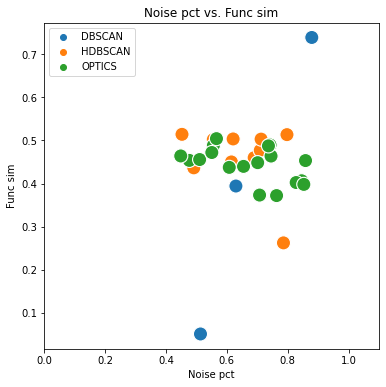

In [98]:
data=modeloutput
x="noise_pct"
y="func_sim"
hue='model'

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=hue,
                s=200
                )
ax.legend(loc='best')

x_proper = x.capitalize().replace('_', ' ')
y_proper = y.capitalize().replace('_', ' ')
ax.set(xlabel=x_proper, 
       ylabel=y_proper,
      title =x_proper + " vs. " + y_proper)
ax.set_xlim(0, 1.1)

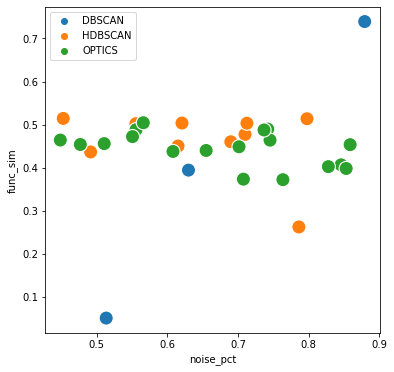

In [50]:
data=modeloutput
x="noise_pct"
y="func_sim"
hue='model'

f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(data=data, x=x, y=y,
                hue=hue,
                s=200
                )
ax.legend(loc='best')

In [73]:
mod = smf.ols("goodplace_pairs_pct ~ noise_pct + model", 
              data=modeloutput[modeloutput.model!='DBSCAN']).fit()
print(mod.summary())

                             OLS Regression Results                            
Dep. Variable:     goodplace_pairs_pct   R-squared:                       0.015
Model:                             OLS   Adj. R-squared:                 -0.064
Method:                  Least Squares   F-statistic:                    0.1894
Date:                 Mon, 06 Dec 2021   Prob (F-statistic):              0.829
Time:                         15:57:21   Log-Likelihood:                 32.534
No. Observations:                   28   AIC:                            -59.07
Df Residuals:                       25   BIC:                            -55.07
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4003      

In [52]:
mod = smf.ols("goodplace_pairs_pct ~ func_sim + embedding", data=modeloutput).fit()
print(mod.summary())

                             OLS Regression Results                            
Dep. Variable:     goodplace_pairs_pct   R-squared:                       0.749
Model:                             OLS   Adj. R-squared:                  0.721
Method:                  Least Squares   F-statistic:                     26.86
Date:                 Mon, 06 Dec 2021   Prob (F-statistic):           2.93e-08
Time:                         15:39:27   Log-Likelihood:                 40.294
No. Observations:                   31   AIC:                            -72.59
Df Residuals:                       27   BIC:                            -66.85
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------